In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import pickle
import PIL.Image as Image

In [2]:
lr = 1.0
num_dummy = 1
Iteration = 300
num_exp = 2

In [3]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

tt = transforms.Compose([transforms.ToTensor()])
tp = transforms.Compose([transforms.ToPILImage()])

In [4]:
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=768, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [5]:
def weights_init(m):
    try:
        if hasattr(m, "weight"):
            m.weight.data.uniform_(-0.5, 0.5)
    except Exception:
        print('warning: failed in weights_init for %s.weight' % m._get_name())
    try:
        if hasattr(m, "bias"):
            m.bias.data.uniform_(-0.5, 0.5)
    except Exception:
        print('warning: failed in weights_init for %s.bias' % m._get_name())

In [6]:
root_path = '.'
data_path = os.path.join(root_path, './data').replace('\\', '/')
print(data_path)
save_path = './results2/'
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist.


././data


In [7]:
shape_img = (28, 28)
num_classes = 10
channel = 1
hidden = 588
dst = datasets.MNIST(data_path, download=True)

In [8]:
import random
num_images_to_select = 5
sel_images = []

In [23]:
recovered_images=[]
rec_label=[]
for idx_net in range(num_images_to_select):
        net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
        net.apply(weights_init)

        print('running %d|%d experiment'%(idx_net, 5))
        net = net.to(device)
        idx_shuffle = np.random.permutation(len(dst))

        for method in ['DLG', 'iDLG']:
            print('%s, Try to generate %d images' % (method, num_dummy))

            criterion = nn.CrossEntropyLoss().to(device)
            imidx_list = []

            for imidx in range(num_dummy):
                idx = idx_shuffle[imidx]
                sel_images.append(idx)
                imidx_list.append(idx)
                tmp_datum = tt(dst[idx][0]).float().to(device)
                tmp_datum = tmp_datum.view(1, *tmp_datum.size())
                tmp_label = torch.Tensor([dst[idx][1]]).long().to(device)
                tmp_label = tmp_label.view(1, )
                if imidx == 0:
                    gt_data = tmp_datum
                    gt_label = tmp_label
                else:
                    gt_data = torch.cat((gt_data, tmp_datum), dim=0)
                    gt_label = torch.cat((gt_label, tmp_label), dim=0)
                print(imidx_list)


            # compute original gradient
            out = net(gt_data)
            y = criterion(out, gt_label)
            dy_dx = torch.autograd.grad(y, net.parameters())
            original_dy_dx = list((_.detach().clone() for _ in dy_dx))

            # generate dummy data and label
            dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
            dummy_label = torch.randn((gt_data.shape[0], num_classes)).to(device).requires_grad_(True)

            if method == 'DLG':
                optimizer = torch.optim.LBFGS([dummy_data, dummy_label], lr=lr)
            elif method == 'iDLG':
                optimizer = torch.optim.LBFGS([dummy_data, ], lr=lr)
                # predict the ground-truth label
                label_pred = torch.argmin(torch.sum(original_dy_dx[-2], dim=-1),
                                          dim=-1).detach().reshape((1,)).requires_grad_(False)
                rec_label.append(label_pred)
                
                                                                                                                               
            history = []
            history_iters = []
            losses = []
            mses = []
            train_iters = []

            print('lr =', lr)
            for iters in range(Iteration):

                def closure():
                    optimizer.zero_grad()
                    pred = net(dummy_data)
                    if method == 'DLG':
                        dummy_loss = - torch.mean(torch.sum(torch.softmax(dummy_label, -1) * torch.log(torch.softmax(pred, -1)), dim=-1))
                        # dummy_loss = criterion(pred, gt_label)
                    elif method == 'iDLG':
                        dummy_loss = criterion(pred, label_pred)

                    dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
#                     L2 Loss between gradient
                    grad_diff = 0
                    for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                        grad_diff += ((gx - gy) ** 2).sum()
                    grad_diff.backward()
                    return grad_diff

                optimizer.step(closure)
                current_loss = closure().item()
                train_iters.append(iters)
                losses.append(current_loss)
                mses.append(torch.mean((dummy_data-gt_data)**2).item())


                if iters % int(Iteration / 30) == 0:
                    current_time = str(time.strftime("[%Y-%m-%d %H:%M:%S]", time.localtime()))
                    print(current_time, iters, 'loss = %.8f, mse = %.8f' %(current_loss, mses[-1]))
                    history.append([tp(dummy_data[imidx].cpu()) for imidx in range(num_dummy)])
                    history_iters.append(iters)

                    for imidx in range(num_dummy):
                        plt.figure(figsize=(12, 8))
                        plt.subplot(3, 10, 1)
                        plt.imshow(tp(gt_data[imidx].cpu()))
                        for i in range(min(len(history), 29)):
                            plt.subplot(3, 10, i + 2)
                            plt.imshow(history[i][imidx])
                            plt.title('iter=%d' % (history_iters[i]))
                            plt.axis('off')
                        if method == 'DLG':
                            plt.savefig(os.path.join(save_path, 'DLG_on_%s_%05d.png' % (imidx_list, imidx_list[imidx])).replace('\\', '/'),
                                        dpi=300 )
                            plt.close()
                        elif method == 'iDLG':
                            plt.savefig(os.path.join(save_path, 'iDLG_on_%s_%05d.png' % (imidx_list, imidx_list[imidx])).replace('\\', '/'),
                                        dpi=300 )
                            plt.close()
                if current_loss < 0.000001: # converge
                        break
                        

            if method == 'DLG':
                loss_DLG = losses
                label_DLG = torch.argmax(dummy_label, dim=-1).detach().item()
                mse_DLG = mses
            elif method == 'iDLG':
                loss_iDLG = losses
                label_iDLG = label_pred.item()
                mse_iDLG = mses


        recovered_image = history[-1][-1] 
        recovered_images.append(recovered_image)
        print('imidx_list:', imidx_list)
        print('loss_DLG:', loss_DLG[-1], 'loss_iDLG:', loss_iDLG[-1])
        print('mse_DLG:', mse_DLG[-1], 'mse_iDLG:', mse_iDLG[-1])
        print('Ground  Truth_label:', gt_label.detach().cpu().data.numpy(), 'lab_DLG:', label_DLG, 'lab_iDLG:', label_iDLG)

        print('******----------------------***************-------------------------------------*****\n\n')



running 0|5 experiment
DLG, Try to generate 1 images
[27367]
lr = 1.0
[2023-11-04 17:22:39] 0 loss = 9.46809769, mse = 1.84346092
[2023-11-04 17:22:44] 10 loss = 0.00000117, mse = 0.00000163
iDLG, Try to generate 1 images
[27367]
lr = 1.0
[2023-11-04 17:22:45] 0 loss = 3.52557278, mse = 0.54222989
[2023-11-04 17:22:50] 10 loss = 0.00000051, mse = 0.00000058
imidx_list: [27367]
loss_DLG: 3.4688736150201294e-07 loss_iDLG: 5.091724233352579e-07
mse_DLG: 5.601038424174476e-07 mse_iDLG: 5.761166335105372e-07
Ground  Truth_label: [2] lab_DLG: 2 lab_iDLG: 2
******----------------------***************-------------------------------------*****


running 1|5 experiment
DLG, Try to generate 1 images
[32883]
lr = 1.0
[2023-11-04 17:22:51] 0 loss = 6.83274078, mse = 0.47665098
[2023-11-04 17:22:56] 10 loss = 0.00000747, mse = 0.00000495
iDLG, Try to generate 1 images
[32883]
lr = 1.0
[2023-11-04 17:23:00] 0 loss = 4.87767267, mse = 0.41106635
[2023-11-04 17:23:07] 10 loss = 0.00000013, mse = 0.0000

In [10]:
# sel_images=[29394,47169,36691,52130,44332]

In [11]:
len(recovered_images)

5

In [12]:
# recovered_images[1]

In [24]:
unique_numbers = []
for num in sel_images:
    if num not in unique_numbers:
        unique_numbers.append(num)
unique_numbers

[19364, 53051, 12673, 27367, 32883, 26603, 20875, 39450]

In [25]:
def load_and_display_images(dataset, random_indices):
    tp = transforms.ToTensor()
    tt = transforms.ToPILImage()
    device = "cpu" 
    selected_images = []
    labels = []
    for img_index in random_indices:
        gt_data = tp(dataset[img_index][0]).to(device)
        gt_data = gt_data.view(1, *gt_data.size())
        labels.append(dataset[img_index][1])
        selected_images.append(tt(gt_data.squeeze(0).cpu()))

    return selected_images, labels

selected_images, selected_labels = load_and_display_images(dst, sel_images)

In [26]:
def calculate_mse(original_image, recovered_image):
    diff = original_image - recovered_image
    mse = torch.mean(diff ** 2)
    return mse.item()

def PSNR(original_image, recovered_image):
    mse = calculate_mse(original_image, recovered_image)
    if mse == 0:
        return float('inf')
    max_pixel_value = 255 
    psnr = 20 * (np.log10(max_pixel_value) - np.log10(np.sqrt(mse)))
    return psnr

def SSIM(original_image, recovered_image):
    c1 = (0.01 * 255) ** 2
    c2 = (0.03 * 255) ** 2
    mu_x = torch.mean(original_image)
    mu_y = torch.mean(recovered_image)
    sigma_x = torch.std(original_image)
    sigma_y = torch.std(recovered_image)
    sigma_xy = torch.mean((original_image - mu_x) * (recovered_image - mu_y))
    # SSIM calculation
    numerator = (2 * mu_x * mu_y + c1) * (2 * sigma_xy + c2)
    denominator = (mu_x ** 2 + mu_y ** 2 + c1) * (sigma_x ** 2 + sigma_y ** 2 + c2)
    ssim_value = numerator/denominator
    return ssim_value.item()

In [27]:
def calculate_metrics(original, recovered):
    mse = calculate_mse(original, recovered)
    psnr = PSNR(original, recovered)
    ssim = SSIM(original, recovered)
    return mse, psnr, ssim

In [30]:
def evaluate_and_plot_metrics(selected_images, recovered_images, transform):
    mse_list = []
    psnr_list = []
    ssim_list = []

    for original_image, recovered_image in zip(selected_images, recovered_images):
        org_data = transform(original_image).unsqueeze(0)
        rec_data = transform(recovered_image).unsqueeze(0)
        mse, psnr, ssim = calculate_metrics(org_data, rec_data)
        mse_list.append(mse)
        psnr_list.append(psnr)
        ssim_list.append(ssim)

    fig, axes = plt.subplots(3, 5, figsize=(20, 8))

    for i, image in enumerate(selected_images[0:5]):
        axes[0, i].imshow(image, cmap='gray')
        axes[0, i].set_title(f"GrounTr: {selected_labels[i]}")
        axes[0, i].axis('off')

    for i, image in enumerate(recovered_images):
        axes[1, i].imshow(image, cmap='gray')
        axes[1, i].set_title(f"Recovered Label: {rec_label[i]}")
        axes[1, i].axis('off')

    for i in range(5):
        axes[2, i].text(0.5, 0.5, f"MSE: {mse_list[i]:.2f}\nPSNR: {psnr_list[i]:.2f}\nSSIM: {ssim_list[i]:.2f}", ha='center', va='center', fontsize=10)
        axes[2, i].axis('off')

    plt.show()

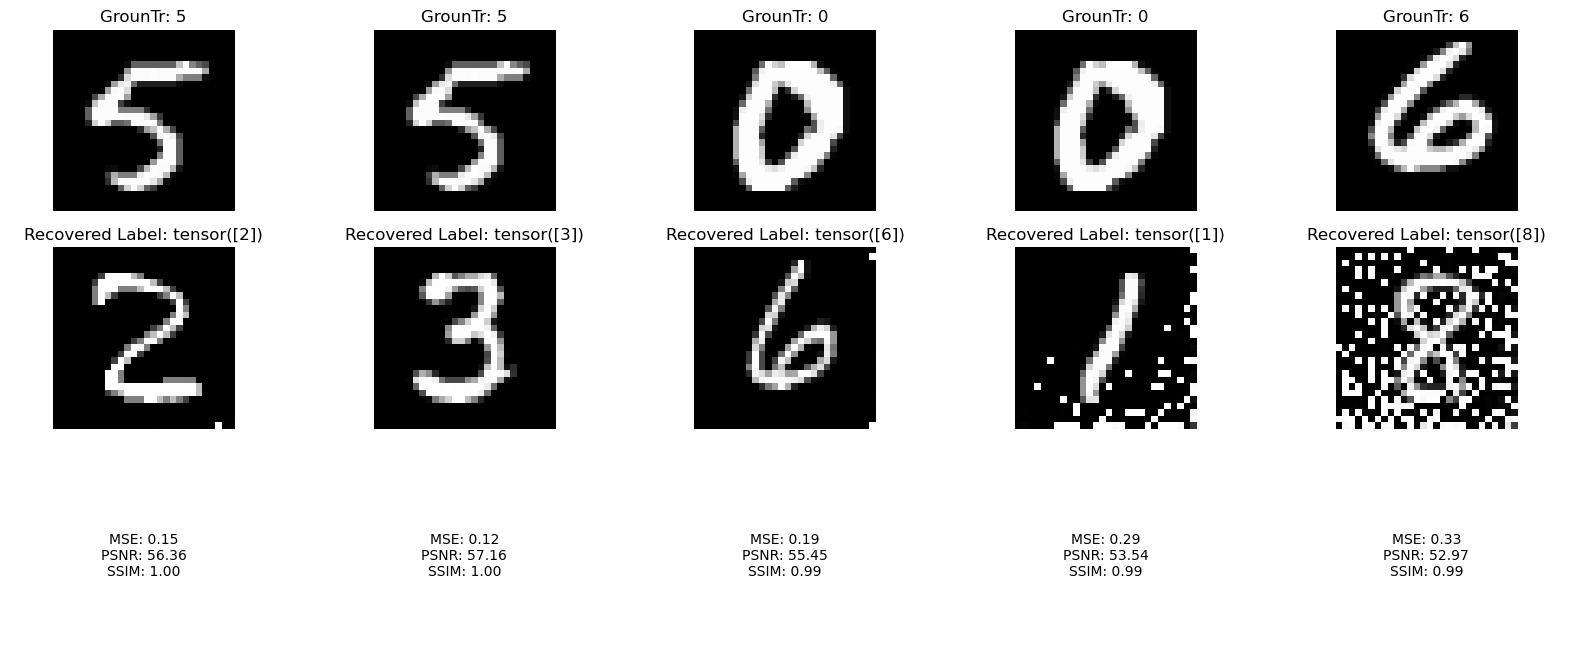

In [31]:
from torchvision import transforms
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor(),])
evaluate_and_plot_metrics(selected_images, recovered_images, transform)

*MSE (Mean Squared Error):* MSE measures the average squared difference between the pixels of two images. A lower MSE indicates a closer match between the original and the recovered image. an MSE of 0.33 suggests that, on average, the pixels in the recovered image differ from the original image by a relatively small amount.

*PSNR (Peak Signal-to-Noise Ratio):* PSNR measures the quality of an image by comparing it to a perfect image (with no noise or distortion). It's expressed in decibels (dB). A higher PSNR indicates a higher quality image. a 52.91 dB is relatively high, suggesting that the quality of the recovered image is quite close to the original.

*SSIM (Structural Similarity Index):* SSIM is a perception-based model that measures the structural similarity between two images. It considers luminance, contrast, and structure. SSIM values range from -1 to 1, where 1 indicates a perfect match. An SSIM of 0.97 is quite high and suggests a strong structural similarity between the original and the recovered image.